# Analyze Model

How well does our trained model perform on unseen data? 

In [1]:
import tensorflow as tf
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np 
from scipy import stats

import os

import pickle as pkl 

# Loss Curve Analysis

Load the (directory of) losses

In [182]:
loss_dir = 'Grid_Search_April_22nd'
loss_files = os.listdir(f'loss/{loss_dir}')

Load each loss curve, also keeping track of the particular instance

In [183]:
losses = {}
for loss in loss_files:
    with open(f'loss/{loss_dir}/{loss}', 'rb') as f:
        temp = pd.read_csv(f)
    losses[loss] = temp

Store the validation loss to quantify performance ... which one did the best? 

In [184]:
train_mse = {}
test_mse = {}

for loss in loss_files:

    train_mse[loss]=float(np.sqrt(losses[loss]['loss'].tail(1)))
    test_mse[loss]=float(np.sqrt(losses[loss]['val_loss'].tail(1)))

# What is the 'best performing' model?
    

C:\Users\tjaou104\AppData\Local\Temp\ipykernel_6672\2128013759.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  train_mse[loss]=float(np.sqrt(losses[loss]['loss'].tail(1)))
C:\Users\tjaou104\AppData\Local\Temp\ipykernel_6672\2128013759.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  test_mse[loss]=float(np.sqrt(losses[loss]['val_loss'].tail(1)))


In [185]:
train_mse

{'loss_trainSeries_testVariables_1052.csv': 0.1296302088617005,
 'loss_trainSeries_testVariables_1083.csv': 0.1527292070221793,
 'loss_trainSeries_testVariables_1116.csv': 0.13385176059648338,
 'loss_trainSeries_testVariables_1119.csv': 0.15150567149493283,
 'loss_trainSeries_testVariables_1181.csv': 0.12856998801133918,
 'loss_trainSeries_testVariables_2355.csv': 0.1494181825655683,
 'loss_trainSeries_testVariables_2556.csv': 0.13165325647532383,
 'loss_trainSeries_testVariables_2607.csv': 0.14610590680179086,
 'loss_trainSeries_testVariables_3186.csv': 0.13462181296202225,
 'loss_trainSeries_testVariables_3195.csv': 0.14789676050999867,
 'loss_trainSeries_testVariables_3826.csv': 0.15308980561645474,
 'loss_trainSeries_testVariables_3842.csv': 0.13035984919485907,
 'loss_trainSeries_testVariables_3978.csv': 0.15038019614782824,
 'loss_trainSeries_testVariables_4138.csv': 0.1339462707098111,
 'loss_trainSeries_testVariables_4305.csv': 0.12727023647329883,
 'loss_trainSeries_testVariab

Factoring in the Feburary 28 loss curves, this takes into account the variables 'solar_radiation', 'temperature', 'CN^2', 'Relative Humidity' ... maybe make a scatter plot? 

(0.1, 0.3)

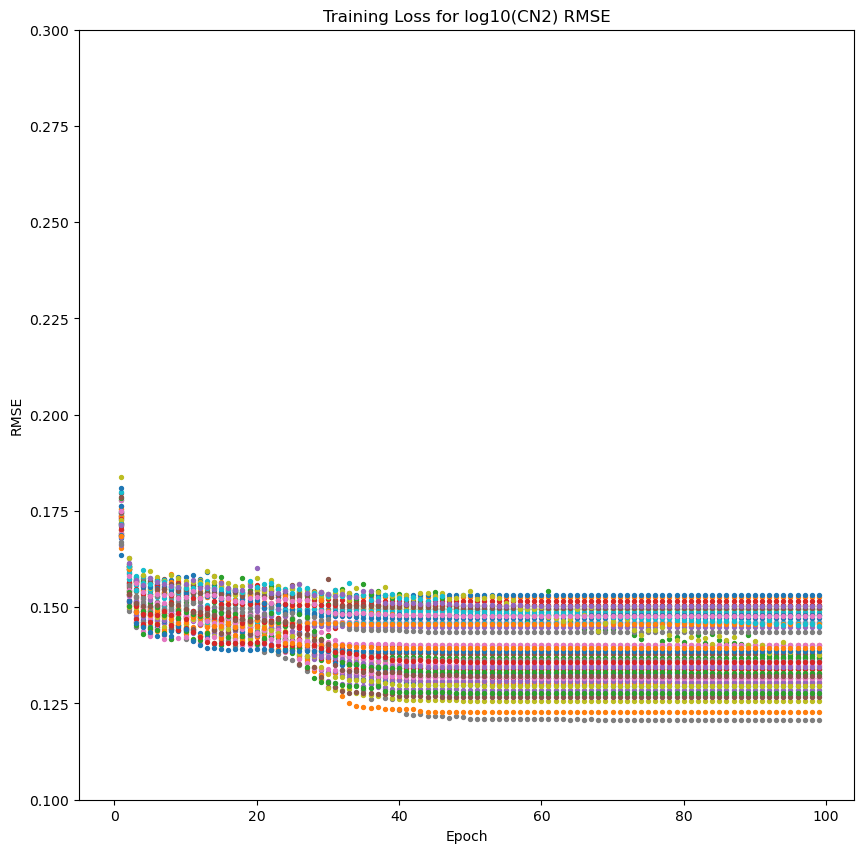

In [226]:
plt.figure(figsize=(10,10))

for ii, loss in enumerate(loss_files):
    y = np.sqrt(losses[loss]['loss'][:])
    epochs = np.arange(len(y))
    plt.scatter(epochs, y, s=8, label=f'{loss}, end={train_mse[loss]}')
    
plt.title('Training Loss for log10(CN2) RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.ylim(0.10,0.30)
#plt.legend()

Make a line plot similar to the paper

In [7]:
num_of_hours = [1,2,3,4,6,12]
tester_mse = [test_mse['loss_oneHour_7006.csv'], test_mse['loss_twoHour_3484.csv'],test_mse['loss_threeHour_6371.csv'], test_mse['loss_fourHour_7641.csv'], test_mse['loss_sixHour_1152.csv'], test_mse['loss_twelveHour_1654.csv']]  
plt.plot(num_of_hours, tester_mse, marker='o')

plt.xlabel('Number of Hours Ahead')
plt.ylabel('Validation RMSE on Log10(CN2)')

KeyError: 'loss_oneHour_7006.csv'

In [25]:
test_mse['loss_oneHour_7006.csv']

TypeError: list indices must be integers or slices, not str

# Testing Model Predictions

Choose input features

In [130]:
input_features = ['relative_humidity', 'solar_radiation', 'CN2', 'temperature', 'day', 'time']

Load the data

In [72]:
from augmentation import jitter, window_slice, window_warp

difference = -1

# Some useful functions

# Routine to normalize between 0 and 1 (Following the atmospheric turbulence paper)

def norm_data(x):
    minX = np.min(x[np.nonzero(x)])
    maxX = np.max(x[np.nonzero(x)])
    
    normed = (x - minX)/(maxX - minX)
    
    # Zero out any values that are above 1
    normed[normed>1] =  0
    
    return normed, minX, maxX

# Routine to normalize between 0 and 1 (Following the atmospheric turbulence paper)

def norm_data_select(x, minX, maxX):  
    normed = (x - minX)/(maxX - minX)
    
    # Zero out any values that are above 1
    normed[normed>1] =  0
    
    return normed, minX, maxX

# Routine to ... UNNORMALIZE. This is done to convert the data back to the original time scale. 

def unnorm_data(x, minX, maxX):
    unnorm_fac = (maxX - minX)
    return x*unnorm_fac + minX
    
# This applies a rolling average on the dataset 

# Function taken from a learnpython article

def roll_average(input_data, window_size):
    result = []
    for i in range(len(input_data) - window_size + 1):
        window = input_data[i:i+window_size]
        window_average = sum(window)/window_size
        result.append(window_average)
        
    return np.array(result)
    
def rollify_training(X, window_size):
    X_features = X.shape[2]
    
    X_roll_len = X.shape[1] - window_size + 1
    
    X_roll = np.empty((len(X), X_roll_len, X_features))
    
    for ii in range(len(X)):
        for jj in range(X_features):
            X_roll[ii,:,jj] = roll_average(X[ii,:,jj], window_size)
            
    return X_roll

def hours_to_int(x):
    if x[0:-2]=='':
        return 0
    else:
        return int(x[0:-2])
    
def convert_to_sec(minute, hour):
    return 3600*hour + 60*minute




def load_data(direc_name, time_steps, input_list, window_size, num_of_examples, full_time_series=False, pad_output_zeros = True,  forecast_len=1, time_res=1, start_index=0):

    total_input = []
    total_output = []
    
    # Files expected
    
    directory_list = [name for name in os.listdir(f'{direc_name}/.')]
    
    num_features = len(input_list)
    print(num_features)
    if ('day' in input_list):
        num_features+= 1
    if ('time' in input_list):
        num_features+= 1
    print(num_features)
    
    
    print(f'Parameter List: {input_list}')
    
    num_of_zeros = 0
    print(start_index)
    
    for jj, name in enumerate(directory_list, start=start_index):
        
        df = pd.read_csv(f'{direc_name}/{name}')
        print(name)
        # rename columns to something more decipherable 
        df = df.rename(columns={'Temp °C':'temperature', 'RH %':'relative_humidity', 'kJ/m^2':'solar_radiation', 'Wind Speed m/s':'wind_speed', 'SOG cm':'SOG','Pressure hPa':'pressure', 'hr:min (UTC)':'time', 'Julian day (UTC)': 'day'})
        # Map the day into a unit circle, and create 'day_sin'  and 'day_cos' to define the x and y components in the circle. 
        df['day_sin'] = np.sin(df['day']*(2.*np.pi/365))
        df['day_cos'] = np.cos(df['day']*(2.*np.pi/365))
        # For time, we convert to string representation
        df['time']=df['time'].astype(str)
        df['minute'] = df['time'].apply(lambda x: int(x[-2:]))
        df['hour'] = df['time'].apply(lambda x: hours_to_int(x))
        df['second'] = convert_to_sec(df['minute'], df['hour'])
        # Map the time into a unit circle 
        df['time_sin']= np.sin(df['second']*(2.*np.pi/86400))
        df['time_cos']= np.cos(df['second']*(2.*np.pi/86400))

        #print(df.columns)
        #input()
        
        # If the prior/future CN2 columns have zero values, then continue to next iteration 
        if(df['CN2']==0).any() or (df['CN2 Future']==0).any():
             #print(jj)
             num_of_zeros += 1
             print(f'number of zeros: {num_of_zeros}')
             print('error data detected. Skipping to next value')
             continue
        
        dataset_weather = np.empty((time_steps, num_features))
        dataset_output = np.empty((output_len, 1))
        
        ###### INPUT DATA #######
        ii= 0
        kk= 0 # index for column
        
        while ii < num_features:
           # print(ii)
            colName = input_list[kk]
            if(colName=='day'):
             
                # include both day_sin and day_cos
                
                dataset_weather[:,ii] = df['day_sin'].to_numpy()
                ii += 1
                dataset_weather[:,ii] = df['day_cos'].to_numpy()
                
            elif(colName=='time'):
                
                # Include both time_sin and time_cos
                
                dataset_weather[:,ii] = df['time_sin'].to_numpy()
                ii += 1
                dataset_weather[:,ii] = df['time_cos'].to_numpy()
               
                
            elif(colName=='CN2'):
                dataset_weather[:,ii] = np.log10(df[colName].to_numpy())
            else:
                
                dataset_weather[:,ii] = df[colName].to_numpy()
            kk += 1
            ii += 1
                
        ###### OUTPUT DATA #######
        
        # In the 0th output, CN2 FUTURE
        
        # First, let's consider every example up to forecast length 
        nn_output  = np.log10(df["CN2 Future"][:forecast_len].to_numpy())
        
        # Next, only consider every time_res example in the final output
        dataset_output[:,0] = nn_output[np.mod(np.arange(len(nn_output)),time_res) == 0]
        
        # Let's consider wildly varying output data. Compute the difference between maximum and minimum. 
        max_CN2 = np.max(np.abs(dataset_output[:,0]))
        min_CN2 = np.min(np.abs(dataset_output[:,0]))
        diff = np.abs(max_CN2 - min_CN2)
        
        if (diff >= -1):
            total_input.append(dataset_weather)
            total_output.append(dataset_output)
            
        if (jj%500==0):
            print(f"Data loaded:{jj}")
            
        if (jj>num_of_examples):
            print("Finished loading data!")
            break;
                
    total_input = np.array(total_input)
    total_output = np.array(total_output)
    
    if(full_time_series):
        return total_input, total_output
    else:
        return total_input, total_output[:,0]




    

# NEW: Load the model & test data 

Compute time resolution

In [2]:
time_res = 15
forecast_len = 360
output_len = int(forecast_len/time_res)

Load da model 

In [67]:
def mse_mod(y_true, y_pred):

    loss = K.mean(K.square(y_pred - y_true), axis=-1)
    loss_true = tf.reduce_mean(loss)
    
    # We add a small epsillion to the MSE. This makes it so that we avoid crazy losses
    return loss_true + 1e-8

fifteenMinutes_6HourForecast = 'trainSeries_15MinInput_6Hour_9487'
fifteenMinutes_12HourForecast = 'trainSeries_15MinInput_12Hour_8893'
newNormOrder = 'trainSeries_newNormOrder_7379'

# Load the models

fifthteenMin_timeRes = 'trainSeries_15MinRes_8254'
noOctober_timeDay = 'trainSeries_timeDay_noOctober_3121'

curr_model = noOctober_timeDay

# Load the test data 

loaded_model_1 = tf.keras.models.load_model(f'models/{curr_model}', custom_objects={'mse_mod':mse_mod})

alt_dict = October

with open(f'Test Data/{curr_model}_testData.pkl', 'rb') as f:
    X_test, y_test = pkl.load(f)


# OLD: Load data based on old train-test splitting paradigm

Start by computing the number of features

In [79]:
input_features = ['relative_humidity', 'solar_radiation', 'temperature', 'day', 'time', 'CN2']
number_of_features = len(input_features)
if ('day' in input_features):
    number_of_features+= 1
if ('time' in input_features):
    number_of_features+= 1

Now load the data using these features

In [123]:

time_len = 720
time_res = 15
forecast_len = 360
output_len = int(forecast_len/time_res)


direc_name = 'Batched Data/October'
start_index =  0

minTrain = [16.29781, -0.3995518, -18.04353, -0.9999907397361901, -0.9441875088341996, -1.0, -1.0, -16.46344155742847]
maxTrain = [99.52488, 71.5599, 32.07004, 0.995918996147179, 1.0, 1.0, 1.0, -13.749579997691106]

# Load data 

X, y = load_data(direc_name, time_len, input_features, 1, 7000, full_time_series=True, forecast_len=forecast_len, time_res=time_res, start_index=start_index)


6
8
Parameter List: ['relative_humidity', 'solar_radiation', 'temperature', 'day', 'time', 'CN2']
0
00020938.csv
Data loaded:0
00020939.csv
00020940.csv
00020941.csv
00020942.csv
00020943.csv
00020944.csv
00020945.csv
00020946.csv
00020947.csv
00020948.csv
00020949.csv
00020950.csv
00020951.csv
00020952.csv
00020953.csv
00020954.csv
00020955.csv
00020956.csv
00020957.csv
00020958.csv
00020959.csv
00020960.csv
00020961.csv
00020962.csv
00020963.csv
00020964.csv
00020965.csv
00020966.csv
00020967.csv
00020968.csv
00020969.csv
00020970.csv
00020971.csv
00020972.csv
00020973.csv
00020974.csv
00020975.csv
00020976.csv
00020977.csv
00020978.csv
00020979.csv
00020980.csv
00020981.csv
00020982.csv
00020983.csv
00020984.csv
00020985.csv
00020986.csv
00020987.csv
00020988.csv
00020989.csv
00020990.csv
00020991.csv
00020992.csv
00020993.csv
00020994.csv
00020995.csv
00020996.csv
00020997.csv
00020998.csv
00020999.csv
00021000.csv
00021001.csv
00021002.csv
00021003.csv
00021004.csv
00021005.csv
00

00021578.csv
00021579.csv
00021580.csv
00021581.csv
00021582.csv
00021583.csv
00021584.csv
00021585.csv
00021586.csv
00021587.csv
00021588.csv
00021589.csv
00021590.csv
00021591.csv
00021592.csv
00021593.csv
00021594.csv
00021595.csv
00021596.csv
00021597.csv
00021598.csv
00021599.csv
00021600.csv
00021601.csv
00021602.csv
00021603.csv
00021604.csv
00021605.csv
00021606.csv
00021607.csv
00021608.csv
00021609.csv
00021610.csv
00021611.csv
00021612.csv
00021613.csv
00021614.csv
00021615.csv
00021616.csv
00021617.csv
00021618.csv
00021619.csv
00021620.csv
00021621.csv
00021622.csv
00021623.csv
00021624.csv
00021625.csv
00021626.csv
00021627.csv
00021628.csv
00021629.csv
00021630.csv
00021631.csv
00021632.csv
00021633.csv
00021634.csv
00021635.csv
00021636.csv
00021637.csv
00021638.csv
00021639.csv
00021640.csv
00021641.csv
00021642.csv
00021643.csv
00021644.csv
00021645.csv
00021646.csv
00021647.csv
00021648.csv
00021649.csv
00021650.csv
00021651.csv
00021652.csv
00021653.csv
00021654.csv

00022999.csv
00023000.csv
00023001.csv
00023002.csv
00023003.csv
00023004.csv
00023005.csv
00023006.csv
00023007.csv
00023008.csv
00023009.csv
00023010.csv
00023011.csv
00023012.csv
00023013.csv
00023014.csv
00023015.csv
00023016.csv
00023017.csv
00023018.csv
00023019.csv
00023020.csv
00023021.csv
00023022.csv
00023023.csv
00023024.csv
00023025.csv
00023026.csv
00023027.csv
00023028.csv
00023029.csv
00023030.csv
00023031.csv
00023032.csv
00023033.csv
00023034.csv
00023035.csv
00023036.csv
00023037.csv
00023038.csv
00023039.csv
00023040.csv
00023041.csv
00023042.csv
00023043.csv
00023044.csv
00023045.csv
00023046.csv
00023047.csv
00023048.csv
00023049.csv
00023050.csv
00023051.csv
00023052.csv
00023053.csv
00023054.csv
00023055.csv
00023056.csv
00023057.csv
00023058.csv
00023059.csv
00023060.csv
00023061.csv
00023062.csv
00023063.csv
00023064.csv
00023065.csv
00023066.csv
00023067.csv
00023068.csv
00023069.csv
00023070.csv
00023071.csv
00023072.csv
00023073.csv
00023074.csv
00023075.csv

00023632.csv
00023633.csv
00023634.csv
00023635.csv
00023636.csv
00023637.csv
00023638.csv
00023639.csv
00023640.csv
00023641.csv
00023642.csv
00023643.csv
00023644.csv
00023645.csv
00023646.csv
00023647.csv
00023648.csv
00023649.csv
00023650.csv
00023651.csv
00023652.csv
00023653.csv
00023654.csv
00023655.csv
00023656.csv
00023657.csv
00023658.csv
00023659.csv
00023660.csv
00023661.csv
00023662.csv
00023663.csv
00023664.csv
00023665.csv
00023666.csv
00023667.csv
00023668.csv
00023669.csv
00023670.csv
00023671.csv
00023672.csv
00023673.csv
00023674.csv
00023675.csv
00023676.csv
00023677.csv
00023678.csv
00023679.csv
00023680.csv
00023681.csv
00023682.csv
00023683.csv
00023684.csv
00023685.csv
00023686.csv
00023687.csv
00023688.csv
00023689.csv
00023690.csv
00023691.csv
00023692.csv
00023693.csv
00023694.csv
00023695.csv
00023696.csv
00023697.csv
00023698.csv
00023699.csv
00023700.csv
00023701.csv
00023702.csv
00023703.csv
00023704.csv
00023705.csv
00023706.csv
00023707.csv
00023708.csv

00024579.csv
00024580.csv
00024581.csv
00024582.csv
00024583.csv
00024584.csv
00024585.csv
00024586.csv
00024587.csv
00024588.csv
00024589.csv
00024590.csv
00024591.csv
00024592.csv
00024593.csv
00024594.csv
00024595.csv
00024596.csv
00024597.csv
00024598.csv
00024599.csv
00024600.csv
00024601.csv
00024602.csv
00024603.csv
00024604.csv
00024605.csv
00024606.csv
00024607.csv
00024608.csv
00024609.csv
00024610.csv
00024611.csv
00024612.csv
00024613.csv
00024614.csv
00024615.csv
00024616.csv
00024617.csv
00024618.csv
00024619.csv
00024620.csv
00024621.csv
00024622.csv
00024623.csv
00024624.csv
00024625.csv
00024626.csv
00024627.csv
00024628.csv
00024629.csv
00024630.csv
00024631.csv
00024632.csv
00024633.csv
00024634.csv
00024635.csv
00024636.csv
00024637.csv
00024638.csv
00024639.csv
00024640.csv
00024641.csv
00024642.csv
00024643.csv
00024644.csv
00024645.csv
00024646.csv
00024647.csv
00024648.csv
00024649.csv
00024650.csv
00024651.csv
00024652.csv
00024653.csv
00024654.csv
00024655.csv

00025212.csv
00025213.csv
00025214.csv
00025215.csv
00025216.csv
00025217.csv
00025218.csv
00025219.csv
00025220.csv
00025221.csv
00025222.csv
00025223.csv
00025224.csv
00025225.csv
00025226.csv
00025227.csv
00025228.csv
00025229.csv
00025230.csv
00025231.csv
00025232.csv
00025233.csv
00025234.csv
00025235.csv
00025236.csv
00025237.csv
00025238.csv
00025239.csv
00025240.csv
00025241.csv
00025242.csv
00025243.csv
00025244.csv
00025245.csv
00025246.csv
00025247.csv
00025248.csv
00025249.csv
00025250.csv
00025251.csv
00025252.csv
00025253.csv
00025254.csv
00025255.csv
00025256.csv
00025257.csv
00025258.csv
00025259.csv
00025260.csv
00025261.csv
00025262.csv
00025263.csv
00025264.csv
00025265.csv
00025266.csv
00025267.csv
00025268.csv
00025269.csv
00025270.csv
00025271.csv
00025272.csv
00025273.csv
00025274.csv
00025275.csv
00025276.csv
00025277.csv
00025278.csv
00025279.csv
00025280.csv
00025281.csv
00025282.csv
00025283.csv
00025284.csv
00025285.csv
00025286.csv
00025287.csv
00025288.csv

00025867.csv
00025868.csv
00025869.csv
00025870.csv
00025871.csv
00025872.csv
00025873.csv
00025874.csv
00025875.csv
00025876.csv
00025877.csv
00025878.csv
00025879.csv
00025880.csv
00025881.csv
00025882.csv
00025883.csv
00025884.csv
00025885.csv
00025886.csv
00025887.csv
00025888.csv
00025889.csv
00025890.csv
00025891.csv
00025892.csv
00025893.csv
00025894.csv
00025895.csv
00025896.csv
00025897.csv
00025898.csv
00025899.csv
00025900.csv
00025901.csv
00025902.csv
00025903.csv
00025904.csv
00025905.csv
00025906.csv
00025907.csv
00025908.csv
00025909.csv
00025910.csv
00025911.csv
00025912.csv
00025913.csv
00025914.csv
00025915.csv
00025916.csv
00025917.csv
00025918.csv
00025919.csv
00025920.csv
00025921.csv
00025922.csv
00025923.csv
00025924.csv
00025925.csv
00025926.csv
00025927.csv
00025928.csv
00025929.csv
00025930.csv
00025931.csv
00025932.csv
00025933.csv
00025934.csv
00025935.csv
00025936.csv
00025937.csv
00025938.csv
00025939.csv
00025940.csv
00025941.csv
00025942.csv
00025943.csv

00026531.csv
00026532.csv
00026533.csv
00026534.csv
00026535.csv
00026536.csv
00026537.csv
00026538.csv
00026539.csv
00026540.csv
00026541.csv
00026542.csv
00026543.csv
00026544.csv
00026545.csv
00026546.csv
00026547.csv
00026548.csv
00026549.csv
00026550.csv
00026551.csv
00026552.csv
00026553.csv
00026554.csv
00026555.csv
00026556.csv
00026557.csv
00026558.csv
00026559.csv
00026560.csv
00026561.csv
00026562.csv
00026563.csv
00026564.csv
00026565.csv
00026566.csv
00026567.csv
00026568.csv
00026569.csv
00026570.csv
00026571.csv
00026572.csv
00026573.csv
00026574.csv
00026575.csv
00026576.csv
00026577.csv
00026578.csv
00026579.csv
00026580.csv
00026581.csv
00026582.csv
00026583.csv
00026584.csv
00026585.csv
00026586.csv
00026587.csv
00026588.csv
00026589.csv
00026590.csv
00026591.csv
00026592.csv
00026593.csv
00026594.csv
00026595.csv
00026596.csv
00026597.csv
00026598.csv
00026599.csv
00026600.csv
00026601.csv
00026602.csv
00026603.csv
00026604.csv
00026605.csv
00026606.csv
00026607.csv

00027856.csv
00027857.csv
00027858.csv
00027859.csv
00027860.csv
00027861.csv
00027862.csv
00027863.csv
00027864.csv
00027865.csv
00027866.csv
00027867.csv
00027868.csv
00027869.csv
00027870.csv
00027871.csv
00027872.csv
00027873.csv
00027874.csv
00027875.csv
00027876.csv
00027877.csv
00027878.csv
00027879.csv
00027880.csv
00027881.csv
00027882.csv
00027883.csv
00027884.csv
00027885.csv
00027886.csv
00027887.csv
00027888.csv
00027889.csv
00027890.csv
00027891.csv
00027892.csv
00027893.csv
00027894.csv
00027895.csv
00027896.csv
00027897.csv
00027898.csv
00027899.csv
00027900.csv
00027901.csv
00027902.csv
00027903.csv
00027904.csv
00027905.csv
00027906.csv
00027907.csv
00027908.csv
00027909.csv
00027910.csv
00027911.csv
00027912.csv
00027913.csv
00027914.csv
00027915.csv
00027916.csv
00027917.csv
00027918.csv
00027919.csv
00027920.csv
00027921.csv
00027922.csv
00027923.csv
00027924.csv
00027925.csv
00027926.csv
00027927.csv
00027928.csv
00027929.csv
00027930.csv
00027931.csv
00027932.csv

00028972.csv
00028973.csv
00028974.csv
00028975.csv
00028976.csv
00028977.csv
00028978.csv
00028979.csv
00028980.csv
00028981.csv
00028982.csv
00028983.csv
00028984.csv
00028985.csv
00028986.csv
00028987.csv
00028988.csv
00028989.csv
00028990.csv
00028991.csv
00028992.csv
00028993.csv
00028994.csv
00028995.csv
00028996.csv
00028997.csv
00028998.csv
00028999.csv
00029000.csv
00029001.csv
00029002.csv
00029003.csv
00029004.csv
00029005.csv
00029006.csv
00029007.csv
00029008.csv
00029009.csv
00029010.csv
00029011.csv
00029012.csv
00029013.csv
00029014.csv
00029015.csv
00029016.csv
00029017.csv
00029018.csv
00029019.csv
00029020.csv
00029021.csv
00029022.csv
00029023.csv
00029024.csv
00029025.csv
00029026.csv
00029027.csv
00029028.csv
00029029.csv
00029030.csv
00029031.csv
00029032.csv
00029033.csv
00029034.csv
00029035.csv
00029036.csv
00029037.csv
00029038.csv
00029039.csv
00029040.csv
00029041.csv
00029042.csv
00029043.csv
00029044.csv
00029045.csv
00029046.csv
00029047.csv
00029048.csv

In [153]:
np.min(X[:,:,0])

30.79419

Normalize data using training data parameters

In [111]:
# Normalize using training normalization parameters 

for ii in np.arange(number_of_features):
        X[:,:,ii], _, _= norm_data_select(X[:,:,ii], minTrain[ii], maxTrain[ii])
        #X_test[:,:,ii],_,_ = norm_data_select(X_test[:,:,ii], minTrain[ii], maxTrain[ii])
        
        if (ii==number_of_features-1):
            y[:,:,0],_,_ = norm_data_select(y[:,:,0], minTrain[ii], maxTrain[ii])
            #y_test[:,:,0],_,_ = norm_data_select(y_test[:,:,0], minTrain[ii], maxTrain[ii])

# Load trained model

Let's start with the static prediction ones

In [ ]:

# Static prediction models 

static_direc = 'Static Time Prediction/'


static_1 = static_direc + 'trainStatic1_1682'
static_2 = static_direc + 'trainStatic2_6543'
static_3 = static_direc + 'trainStatic3_8010'
static_4 = static_direc + 'trainStatic4_9970'
static_5 = static_direc + 'trainStatic5_2533'
static_6 = static_direc + 'trainStatic6_7528'
static_7 = static_direc + 'trainStatic7_3682'
static_8 = static_direc + 'trainStatic8_3620'
static_9 = static_direc + 'trainStatic9_2710'
static_10 = static_direc + 'trainStatic10_2452'
static_11 = static_direc + 'trainStatic11_9227'
static_12 = static_direc + 'trainStatic12_3873'



static_direcs = [static_1, static_2, static_3, static_4, static_5, static_6, static_7, static_8, static_9, static_10, static_11, static_12]
loaded_models = []

for static_model in static_direcs:
    loaded_models.append()
    


Time series predictions 

In [4]:

# Model directories

# Week of March 4th Models

vinso_12_2 = 'timeSeries12_320Neurons_3Window_1310'
vinso_12 = 'timeSeries12_wider_5518'
vinso_9 = 'timeSeries9_4975'
vinso_6 = 'timeSeries6_8843'
vinso_3 = 'timeSeries3_4870'


# March 12th models

singleShot_12 = 'timeSeries12_singleShot_base_6691'
singleShot_9 = 'timeSeries9_singleShot_1319'
singleShot_6 = 'timeSeries6_singleShot_7836'
singleShot_biDirec = 'timeSeries12_base_bidirec_2662'

# March 18th Models

jitter = 'train12_jitter_6858'
windowSlice = 'train12_window_slice_3733'
windowWarp = 'train12_windowwarp_3911'
oneWindow = 'timeSeries12_base_oneWindow_5550'

# Feature Engineered Models

diff_11 = "train_diff_11_8528"
diff_13 = "train_diff_13_2342"

# Varying forecast models

train_2 = 'TrainSeries2_4244'
train_3 = 'TrainSeries3_7021'
train_4 = 'TrainSeries4_3986'
train_5 = 'trainSeries5_6144'
train_6 = 'trainSeries6_8141'
train_7 = 'trainSeries7_3798'
train_8 = 'trainSeries8_5771'
train_9 = 'trainSeries9_7705'
train_10 = 'trainSeries10_3605'
train_11 = 'trainSeries11_3402'

# 4 Hour predictions using the latest normalization technology 

train_4_new = 'trainSeries_4Hour_9339'
train_4_old = 'TrainSeries4_3986'

# Latest models w/ higher time resolution 

#highTimeRes_30k = 'trainSeries_60Min_30k_6757'
highTimeRes_30k = 'trainSeriesMin_lossMSE_4818'

highTimeRes_38k = 'trainSeriesMin_lossMSE_2547'

# More complicated network 
highTimeRes_moreNeurons = 'trainSeriesMin_12hr_1400Neurons_4672'

# w/ 61 minute time skip 
highTimeRes_61MinSkip = 'trainSeries_61Min_Skip_3898'

# one hour time window 
highTimeRes_oneHourWindow = 'trainSeries_oneHourWindow_1659'

# Four Hours
highTimeRes_FourHour = 'trainSeries_oneHourWindow_4Hour_5364'

#18 Hour Input
highTimeRes_18HourInput = 'trainSeries_18HourInput_1936'

# Lower Res Output
fifthteenMin_timeRes = 'trainSeries_15MinRes_8254'
thirtyMin_timeRes = 'trainSeries_30MinRes_4173'

fifteenMin_fullNorm = 'trainSeries_15MinInput_6Hour_fullNorm_5621'

# Load the models

loaded_model_1 = tf.keras.models.load_model(f'models/{fifteenMin_fullNorm}', custom_objects={'mse_mod':mse_mod})
#loaded_model_2 = tf.keras.models.load_model(f'models/{train_4_old}')
#

NameError: name 'mse_mod' is not defined

For the time series, let's plot some predictions. Design a colormap based on the RMSE between points

In [122]:
def rms(y_true, y_pred):
    root_mean = np.sqrt((y_true - y_pred)**2)
    return root_mean 

def rms_true(y_true, y_pred):
    root_mean = np.sqrt(np.mean((y_true - y_pred)**2))
    return root_mean

def mse(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    return mse


index= 3600
X_test_pred = tf.expand_dims(X[index], axis=0)
ronso = loaded_model_1.predict(X_test_pred, verbose=False)
ronso = np.array(ronso[0]).flatten()
truth = np.array(y[index]).flatten()
error_gradient =rms(truth, ronso)
print(np.mean(error_gradient))
hrs = np.arange(time_len)

# For plotting, unnormalize

minOut = minTrain[-1]
maxOut = maxTrain[-1]

truth = 10**(unnorm_data(truth, minOut, maxOut))
ronso = 10**(unnorm_data(ronso, minOut, maxOut))


0.22971368928721514


In [116]:
def min_to_hour(minute):
    return minute/60


hrs_2 = min_to_hour(np.arange(0,output_len*15,15))
hrs_2

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25,
       5.5 , 5.75])

C:\Users\tjaou104\AppData\Local\Temp\ipykernel_29948\2248873871.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(hrs_2, ronso , marker = 'd', facecolors='none', edgecolors=edgecolors, cmap='viridis_r', label='prediction', s=36)


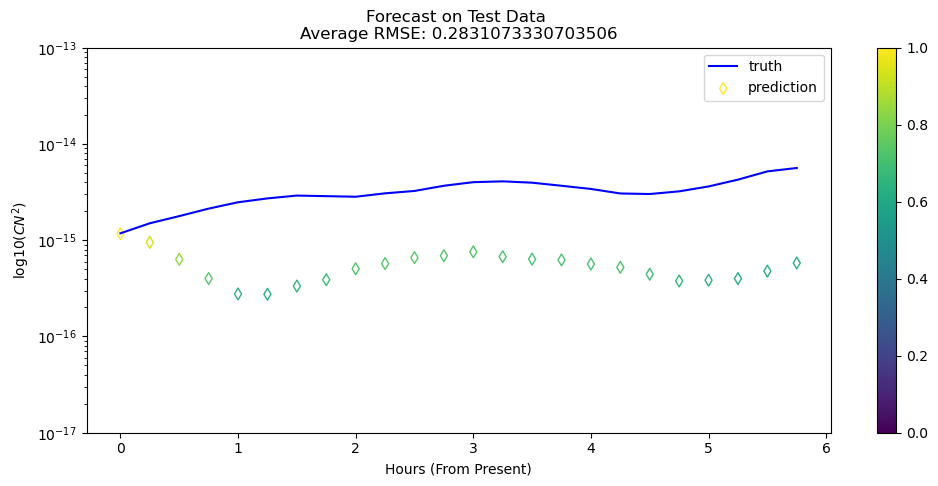

In [121]:
hrs = np.arange(output_len)

cmap = plt.get_cmap('viridis_r')
edgecolors = cmap(error_gradient)

plt.figure(figsize=(12,5))
plt.plot(hrs_2, truth, color='blue', label = 'truth')
plt.scatter(hrs_2, ronso , marker = 'd', facecolors='none', edgecolors=edgecolors, cmap='viridis_r', label='prediction', s=36)

#  c = error_gradient[:time_len], cmap='viridis_r',

#plt.plot(hrs_2, truth[:output_len], 'd', mfc='none', markersize=12, label='truth')
#plt.plot(hrs_2, truth[:output_len], color='blue')

plt.colorbar()
plt.ylabel(r'log10($CN^2$)')
plt.xlabel('Hours (From Present)')
plt.ylim(10**-17, 10**-13)
plt.yscale('log')
plt.title(f'Forecast on Test Data \nAverage RMSE: {np.mean(error_gradient)}')
plt.legend()
plt.savefig(f'Figure Plots/ex_{index}_{output_len}.pdf', format='pdf', bbox_inches='tight')


For smaller range forecasts, lets append multiple forecasts together and see how it looks

# Comparision Between Models

In [63]:
index = 48
X_test_pred = tf.expand_dims(X_test[index], axis=0)
ronso = loaded_model_1.predict(X_test_pred, verbose=False)
ronso = np.array(ronso[0]).flatten()
truth = np.array(y_test[index]).flatten()

error_gradient =rms(truth[:time_len], ronso[:time_len])
hrs = np.arange(time_len-2)

# For plotting, unnormalize
ronso_2 = loaded_model_2.predict(X_test_pred, verbose=False)
ronso_2 = np.array(ronso_2[0]).flatten()
error_gradient_2 = rms(truth[:time_len], ronso_2[:time_len])

# Unnormalize

truth = 10**(unnorm_data(truth, minOut, maxOut))
ronso = 10**(unnorm_data(ronso, minOut, maxOut))
ronso_2 = 10**(unnorm_data(ronso_2, minOut, maxOut))

# Make plots for both 

fig, ax = plt.subplots(1,2, figsize=(20,10))

ax[0].plot(hrs, truth[:time_len-2], marker = 'x')
im1 = ax[0].scatter(hrs, ronso[:time_len-2] , c = error_gradient[:10], cmap='viridis', marker = 'o')
ax[0].plot(hrs, ronso[:time_len-2], color='black')
cbar1 = plt.colorbar(im1, ax=ax[0])

ax[0].set_ylabel('log10(CN^2)')
ax[0].set_ylim(10**-17, 10**-13)
ax[0].set_yscale('log')
ax[0].set_title('With Bidirectional Layers')


ax[1].plot(hrs, truth[:time_len-2], marker = 'x')
im2 = ax[1].scatter(hrs, ronso_2[:time_len-2], c= error_gradient_2[:10])
ax[1].plot(hrs, ronso_2[:time_len-2], color='black')
cbar2 = plt.colorbar(im2, ax=ax[1])
ax[1].set_title('Without Bidirectional Layers')


ax[1].set_ylabel('log10(CN^2)')
ax[1].set_ylim(10**-17, 10**-13)
ax[1].set_yscale('log')


NameError: name 'loaded_model_2' is not defined

Let's compute an overall metric ... how about computing the RMSE over the entire testing dataset? 

In [103]:
RMSEs = []
#RMSEs_2 = []
#time_len_window = 4
#time_len_window_2 = 4
time_len_window = output_len

for ii,x in enumerate(X):
    
    print(ii) 
    funky = tf.expand_dims(x, axis=0)
    
    preds = loaded_model_1.predict(funky, verbose=False)
    #preds_2 = loaded_model_2.predict(funky, verbose=False)
    
    truth = np.array(y[ii]).flatten()
    
    preds = np.array(preds[0]).flatten()
    #preds_2 = np.array(preds_2[0]).flatten()
    
    rmse = mse(truth, preds)
    #rmse_2 = rms(truth[:time_len_window_2], preds_2[:time_len_window_2])
    
    RMSEs.append(rmse)
    #RMSEs_2.append(rmse_2)
    print(np.mean(RMSEs))  
    if (ii>678):
        print("finished")
        break; 
        
#print(np.mean(RMSEs))   
#print(np.mean(RMSEs_2))

0
0.0005938274978412008
1
0.0010560516622272432
2
0.0016825370034125053
3
0.0024697216120501573
4
0.003189040579607496
5
0.0036929208212533858
6
0.003978948418130942
7
0.004096243190272899
8
0.004126944452209954
9
0.0041446397100678885
10
0.004151442263536914
11
0.004154893074073656
12
0.004178937614806859
13
0.004209445148300448
14
0.004229723688584608
15
0.004226379890285226
16
0.004198883705172182
17
0.004147597178903021
18
0.004097467185018882
19
0.00405927701982724
20
0.004039234513997109
21
0.004046442090562479
22
0.0040858632671227765
23
0.004149535712503763
24
0.004238156276317974
25
0.004343159883672155
26
0.004471677189594965
27
0.004600855546674215
28
0.0047578554389318415
29
0.004912400216099792
30
0.005075494459384365
31
0.005239669108692179
32
0.00542649505009599
33
0.005626804227217186
34
0.005837470923757744
35
0.006042468763047148
36
0.006235437851738751
37
0.006394345659940789
38
0.006514478513391038
39
0.006619974731819136
40
0.006708170222038051
41
0.006779568151001

0.005535988559523009
333
0.005526091814808187
334
0.005516590214164207
335
0.005507490167734566
336
0.005498379028448647
337
0.00548927407458258
338
0.005480233759283598
339
0.0054707712222109555
340
0.005461138872265532
341
0.0054516569418769645
342
0.0054421389156130056
343
0.005432536701233347
344
0.005423398978690861
345
0.005414408611537799
346
0.005405886678691628
347
0.005398030548805619
348
0.00539048869283497
349
0.005383705927173191
350
0.005377626420156459
351
0.005372273265919026
352
0.005368245537469202
353
0.005365654410354522
354
0.005364311238168062
355
0.005364006029468429
356
0.0053652483251208595
357
0.005368085203331884
358
0.005371839564592931
359
0.005377258936635766
360
0.005384212615858612
361
0.005392529495225124
362
0.005401668293661726
363
0.00541173946669267
364
0.0054215973845901785
365
0.005431435443172811
366
0.00544190367344474
367
0.005452340299708769
368
0.00546224910900192
369
0.005470427871137055
370
0.00547777409500631
371
0.005483822265810571
372
0

KeyboardInterrupt: 

In [104]:
np.shape(RMSEs)

(574,)

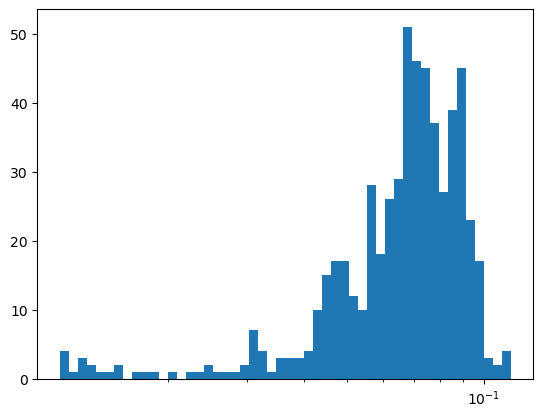

In [105]:
def plot_loghist(x, bins):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins)
    plt.xscale('log')


plot_loghist(np.sqrt(RMSEs), 50)

In [106]:
np.max(np.sqrt(RMSEs))

0.11496692193051135

In [191]:
import heapq

def minN(lst, n=10):
    # Enumerate the list to pair each element with its index
    enumerated_lst = list(enumerate(lst))
    
    # Use heapq.nsmallest with a key function to sort by the list values
    smallest_elements_with_indices = heapq.nsmallest(n, enumerated_lst, key=lambda x: x[1])
    
    # Extract the indices and values separately if needed
    indices, values = zip(*smallest_elements_with_indices)
    
    return list(indices), list(values)


# same thing, but for n largest
def maxN(lst, n=10):
    # Enumerate the list to pair each element with its index
    enumerated_lst = list(enumerate(lst))
    
    # Use heapq.nlargest with a key function to sort by the list values
    largest_elements_with_indices = heapq.nlargest(n, enumerated_lst, key=lambda x: x[1])
    
    # Extract the indices and values separately if needed
    indices, values = zip(*largest_elements_with_indices)
    
    return list(indices), list(values)

mean_RMSEs = np.mean(RMSEs, axis=1)

In [193]:
total_indices = np.arange(len(mean_RMSEs))
max_indices,_ = maxN(mean_RMSEs, n=300)
min_indices,_ = minN(mean_RMSEs, n=300)


total_minus_max = np.setdiff1d(total_indices, max_indices)
central_indices = np.setdiff1d(total_minus_max, min_indices)


central_indices.sort()
max_indices.sort()
min_indices.sort()
    

In [194]:
min_indices

[40,
 42,
 48,
 49,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 63,
 66,
 68,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 171,
 172,
 173,
 174,
 175,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 288,
 289,
 290,
 291,
 292,
 293,
 294,
 295,
 296,
 297,
 298,
 299,
 300,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 318,
 319,
 320,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 329,
 330,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357,
 360,
 400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 408,
 409,
 410,
 411,
 412,
 413,
 414,
 415,
 416,
 417,
 418,
 419,
 420,
 421,
 422,
 423,
 424,
 425,
 502,
 503,
 504,
 505,
 506,
 507,
 508,
 509,
 584,
 58

# DEPRECIATED

Plotting Test RMSE vs. Forecast Length 

Text(0.5, 0, 'Forecast Series Length')

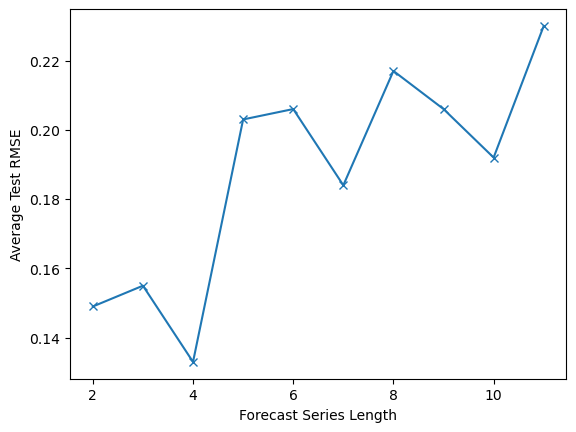

In [69]:
RMSEs_forecast = [0.149, 0.155, 0.133, 0.203, 0.206, 0.184, 0.217, 0.206, 0.192, 0.23]
timeLens = np.arange(2,12)
plt.plot(timeLens, RMSEs_forecast, marker = 'x')
plt.ylabel('Average Test RMSE')
plt.xlabel('Forecast Series Length')

Static Predictions

Plot model prediction vs. ground truths

In [64]:
model_predictions = []

for ii,x in enumerate(X_roll_test):
    print(ii)
    funky = tf.expand_dims(x, axis=0)
    preds = loaded_model.predict(funky, verbose=False)
    model_predictions.append(preds)
    
model_predictions = np.array(model_predictions)
Cn2_pred = model_predictions[:,0,0]
#r0_pred = model_predictions[:,0,1]

Cn2_true = y_test[:,0,0]
#r0_true = y_test[:,0,1]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Results on training data
Slope:1.113320864494608, intercept:-0.021167209522354943, r_value:0.8036351205908453


Text(0.5, 1.0, 'Ground Truths vs. Model Predictions -- $CN^2$\nR2 Value: 0.8036351205908453 -- Slope of Best Fit: 1.113320864494608')

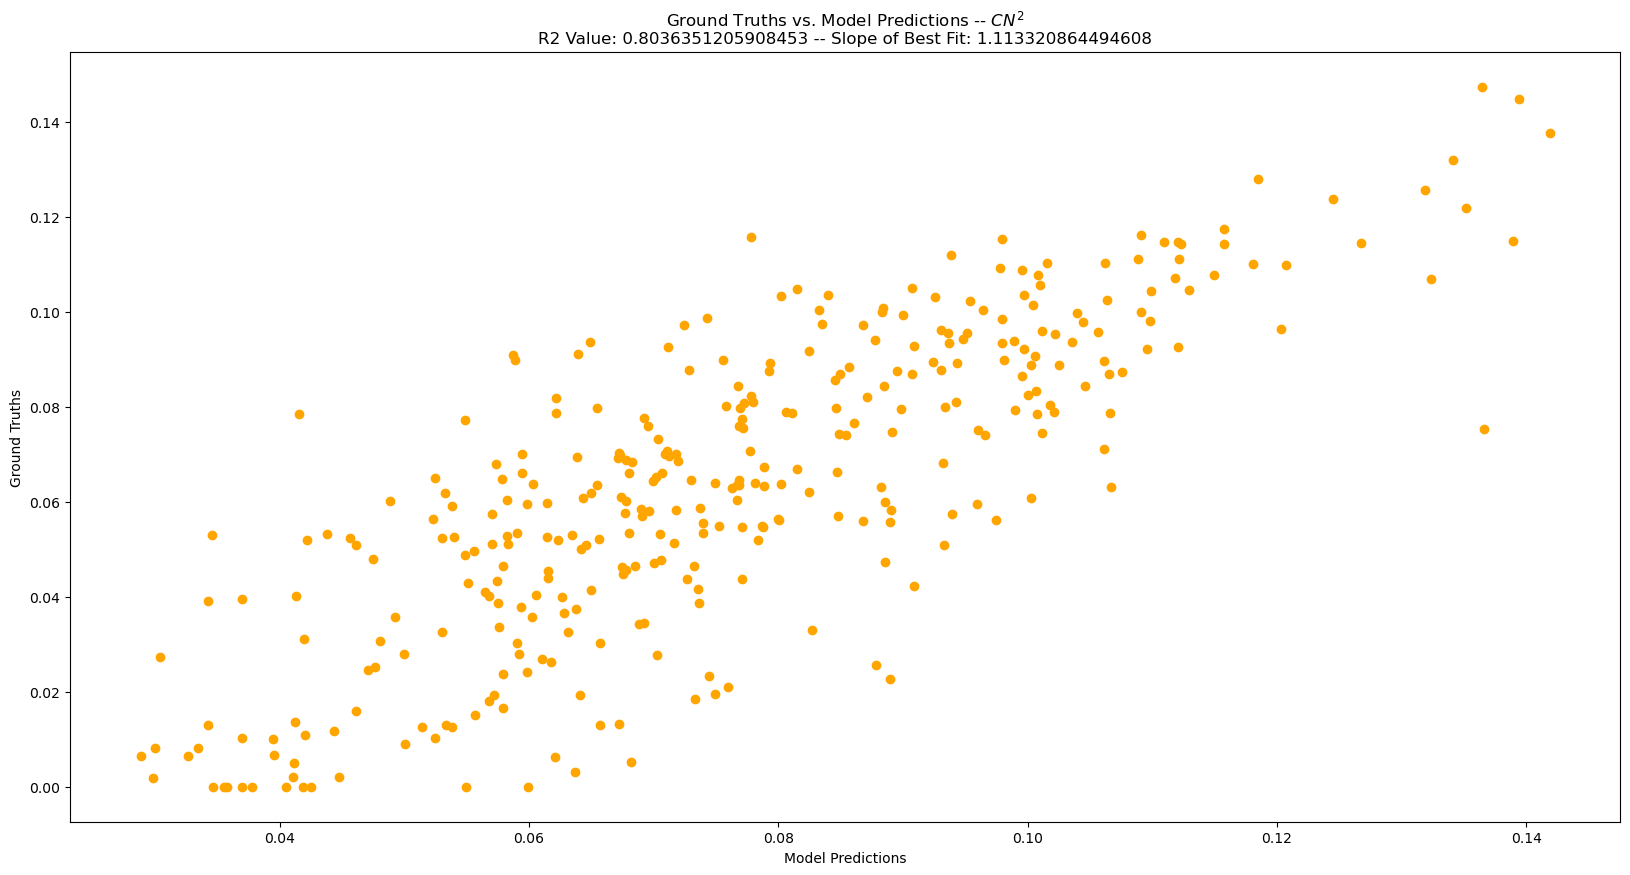

In [65]:
# Compute R2 value

slope_cn, intercept_cn, r_value_cn, p_value_cn, std_err_cn = stats.linregress(Cn2_pred, Cn2_true)

print("Results on training data")
print(f"Slope:{slope_cn}, intercept:{intercept_cn}, r_value:{r_value_cn}")

#slope_r0, intercept_r0, r_value_r0, p_value_r0, std_err_r0 = stats.linregress(r0_pred, r0_true)

#print("Results on training data")
#print(f"Slope:{slope_r0}, intercept:{intercept_r0}, r_value:{r_value_r0}")

fig, ax = plt.subplots(1,1, figsize=(20,10))


ax.scatter(Cn2_pred, Cn2_true, color='orange')
ax.set_xlabel('Model Predictions')
ax.set_ylabel('Ground Truths')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_title(f'Ground Truths vs. Model Predictions -- $CN^{2}$\nR2 Value: {r_value_cn} -- Slope of Best Fit: {slope_cn}')



#plt.savefig(f'R2Plots/{model_direc}.png', bbox_inches='tight')

# Plot Params 

ValueError: x and y must have same first dimension, but have shapes (10,) and (1080,)

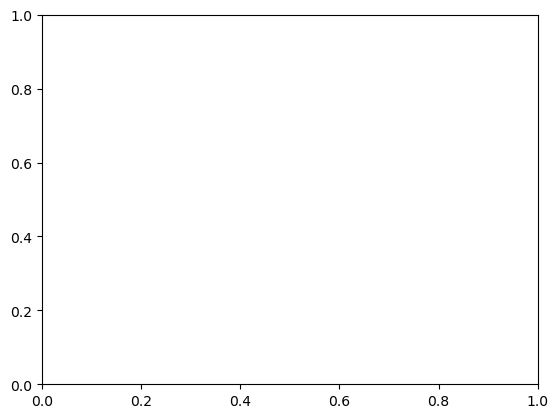

In [174]:
hrs = np.arange(10)

index = 20

plt.plot(hrs, X_train[index,:,0], label='solar_radiation')
plt.plot(hrs, X_train[index,:,1], label='relative_humidity')
plt.plot(hrs, X_train[index,:,2], label='CN2')
plt.plot(hrs, X_train[index,:,3], label='Temperature')
plt.legend()
plt.show()

Augment the dataset

ValueError: x and y must have same first dimension, but have shapes (10,) and (720,)

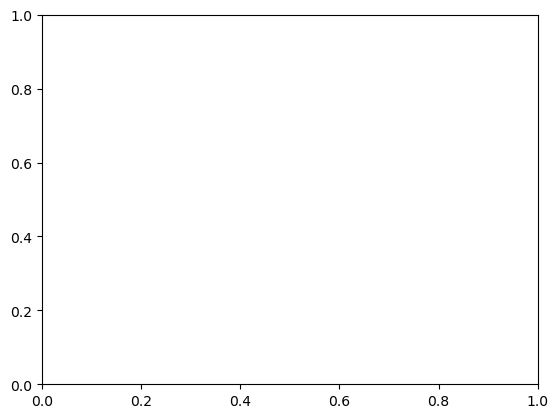

In [68]:
X_aug = window_warp(X_train)
hrs = np.arange(10)


index = 9

plt.plot(hrs, X_aug[index,:,0], label='solar_radiation')
plt.plot(hrs, X_aug[index,:,1], label='relative_humidity')
plt.plot(hrs, X_aug[index,:,2], label='CN2')
plt.plot(hrs, X_aug[index,:,3], label='Temperature')
plt.legend()
plt.show()


# Plot the Distribution of CN2 values

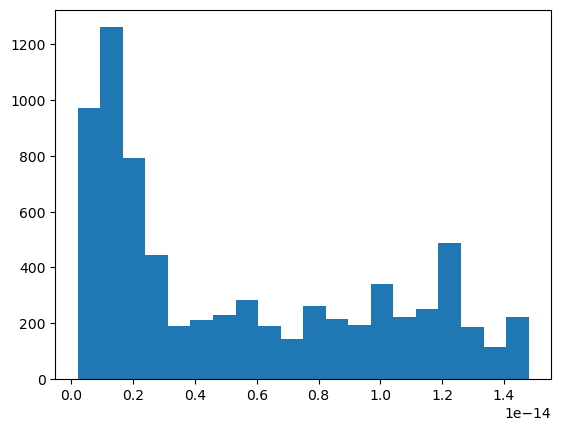

In [69]:
cn2_hist_train = 10**(unnorm_data(y_train.flatten(), minOut, maxOut))
cn2_hist_test = 10**(unnorm_data(y_test.flatten(), minOut, maxOut))

cn2_hist_max = np.array([np.max(datapt) for datapt in cn2_hist_train])
cn2_hist_min = np.array([np.min(datapt) for datapt in cn2_hist_train])

hist, bins,_ = plt.hist(cn2_hist_min, bins=20)

To give a sense of any possible bias within the training dataset, make a histogram of $CN^{2}$ values

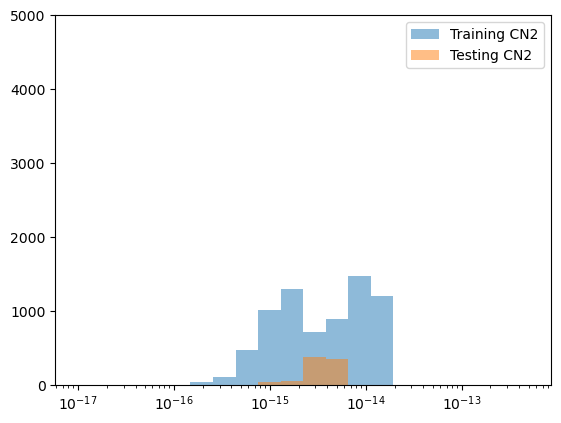

In [70]:
logbins = np.logspace(np.log10(1e-17),np.log10(5e-13), len(bins))

plt.hist(cn2_hist_train, bins=logbins, label = 'Training CN2', alpha=0.5)
plt.hist(cn2_hist_test, bins=logbins, label = 'Testing CN2', alpha=0.5)
plt.xscale('log')
plt.ylim(0,5000)
plt.legend()